In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import camb
from getdist import plots as ps
from getdist.gaussian_mixtures import GaussianND
from hd_mock_data import hd_data
from hdfisher import utils, fisher
from hd_pk import cmb_from_pk
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['figure.dpi'] = 250

# CMB-HD Non-CDM Forecasts

In this notebook, we reproduce the plots and tables for the CMB-HD forecasts in [MacInnis & Sehgal (2024)](https://arxiv.org/abs/2405.12220) with non-CDM-only models.

If you would like to save the plots created below:
- change `save = False` to `save = True`
- (optional) change the `output_dir` to the absolute path of the directory where you want to save the plots, e.g. `output_dir = '/path/to/output'`. By default, this is whatever directory you're running this notebook from.

In [2]:
save = False
output_dir = os.getcwd()

In [3]:
if save:
    print('The plots will be saved in the following directory:', output_dir)

Below, we define the multipole ranges, the type of spectra used (delensed, as opposed to lensed) and the warm dark matter (WDM) masses we consider. 

In [4]:
datalib = hd_data.HDMockData(version='v1.1') # fix the version to ensure results are reproduced
lmin = datalib.lmin
lmax = datalib.lmax
lmaxTT = datalib.lmaxTT
ells = np.arange(lmaxTT+1)
cmb_type = 'delensed'
masses = list(range(1,13)) # WDM masses

---

# Plot the transfer functions for 1 keV WDM (Figure 3)

We plot the transfer function from [Marsh (2016)](https://arxiv.org/abs/1605.05973) that we use on the non-linear matter power spectrum for a 1 keV WDM model at 15 redshifts in the range $z \in [0,14]$. At higher redshifts, we use the linear transfer function of [Viel et. al. (2005)](https://arxiv.org/abs/astro-ph/0501562). For comparison, we also plot the non-linear transfer function of [Viel et. al. (2012)](https://arxiv.org/abs/1107.4094).

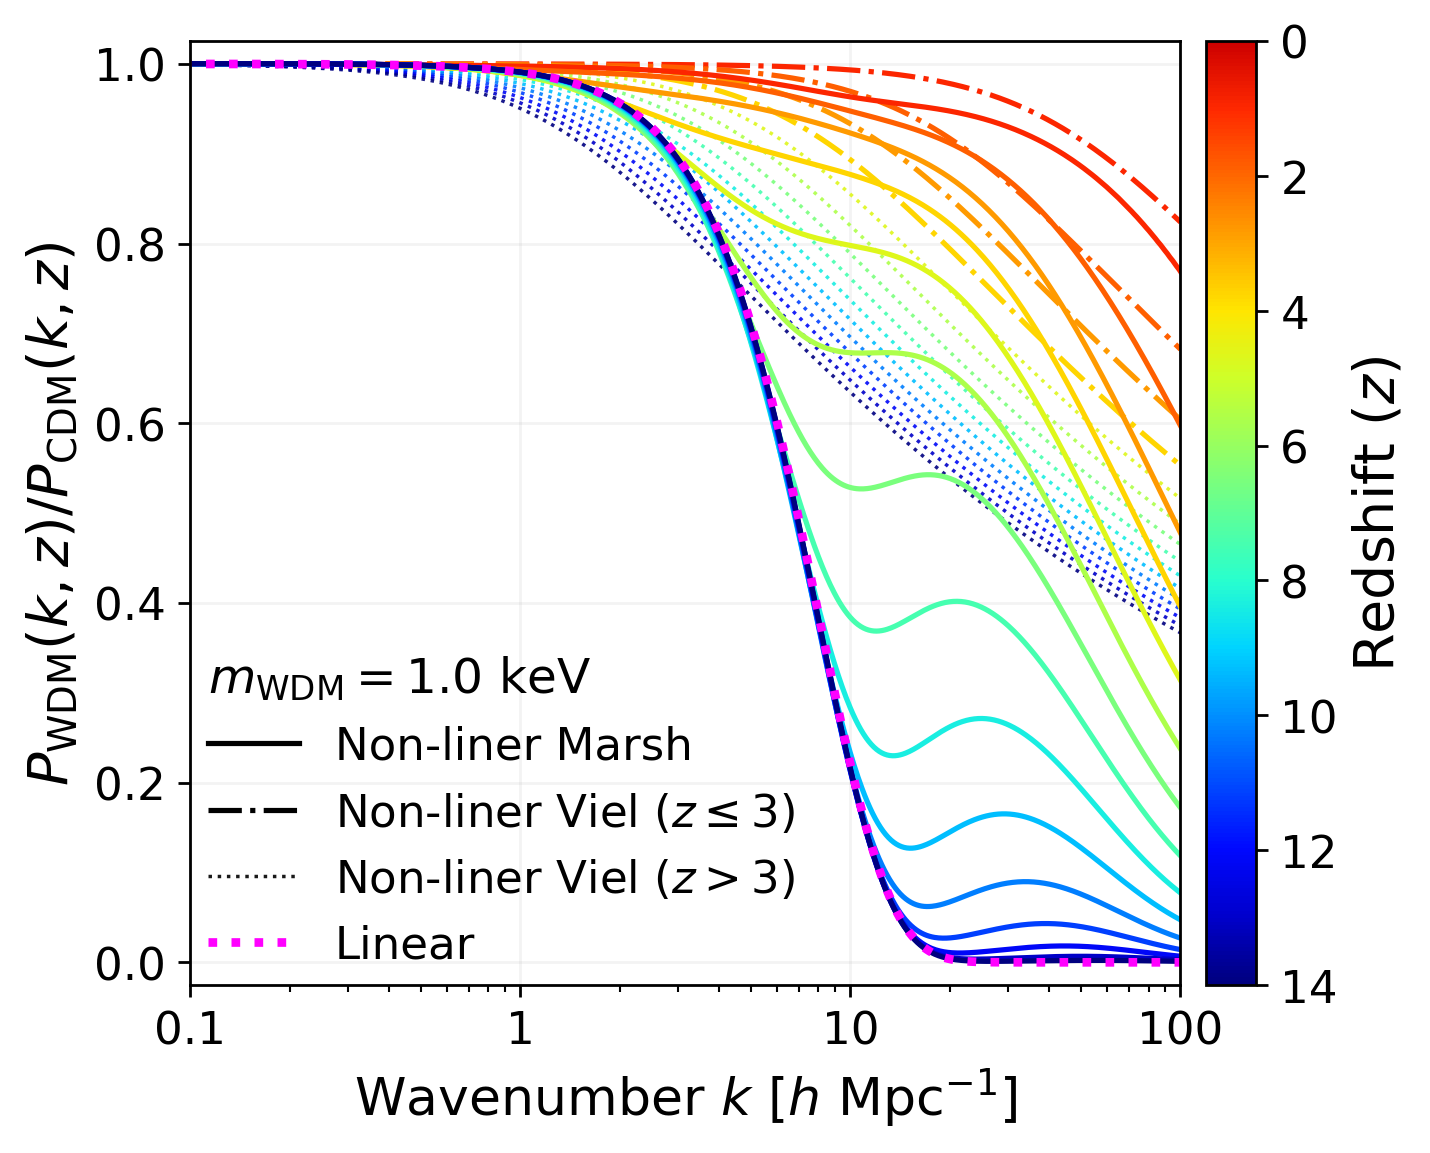

In [5]:
m_wdm = 1 # keV
h = 0.6736 # reduced hubble constant
Omega_dm = 0.12 / h**2 # dark matter density parameter

plt_zs = list(range(15))
plt_khmin = 0.01 # units of h/Mpc
plt_khmax = 100
plt_khs = np.logspace(-2, 2, 1000) # in h / Mpc
plt_ks = plt_khs * h

labelsize = 16
legendsize = 13
ticksize = 13
plt.rcParams['legend.title_fontsize'] = 14
cmap = plt.cm.jet_r
norm = plt.Normalize(vmin=-1, vmax=14)
# to make the plot easier to read, we don't use the full range of the colormap.
# the following function is from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(cmap, minval=norm(0.0), maxval=norm(14.0), n=15)
new_norm = plt.Normalize(vmin=0, vmax=14)

# create the figure:
fig, (ax, cbar_ax) = plt.subplots(ncols=2, figsize=(5.5,5), gridspec_kw={'width_ratios': [20, 1]})

# make the color bar:
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=new_cmap, norm=new_norm, orientation='vertical')
cbar_ax.set_ylabel(r'Redshift ($z$)', fontsize=labelsize)
cbar_ax.tick_params(labelsize=ticksize)
cbar_ax.invert_yaxis()

# plot the transfer functions:
ax.margins(0.025)
# set the legend labels:
ax.plot([], [], color='k', markersize=5, label='Non-liner Marsh')
ax.plot([], [], color='k', ls='-.',  label='Non-liner Viel ($z \leq 3$)')
ax.plot([], [], color='k', ls=':', lw=1, alpha=0.9,  label='Non-liner Viel ($z > 3$)')
# Viel et. al. non-linear:
for z in plt_zs:
    if z <= 3:
        plt_kwargs = {'ls': '-.'}
    else:
        plt_kwargs = {'ls': ':', 'lw': 1, 'alpha': 0.9}
    ax.plot(plt_ks/h, cmb_from_pk.wdm_transfer_nonlin_viel(plt_ks/h, z, m_wdm), color=new_cmap(norm(z)), **plt_kwargs)
# Marsh non-linear:
for z in plt_zs:
    ax.plot(plt_ks/h, cmb_from_pk.wdm_transfer(plt_ks, z, m_wdm, Omega_dm, h), color=new_cmap(norm(z)))
# Viel et. al. linear:
ax.plot(plt_ks/h, cmb_from_pk.wdm_transfer_lin_viel(plt_ks/h, m_wdm, Omega_dm, h), color='magenta', ls=':', lw=2.5, label='Linear')

# finish the plot
legend = ax.legend(title=r'$m_\mathrm{WDM} = %.1f$ keV' % m_wdm, loc=(0.0,0.0), fontsize=legendsize, frameon=False)
legend._legend_box.align = "left"
ax.set_xlabel(r'Wavenumber $k~[h~\mathrm{Mpc}^{-1}]$', fontsize=labelsize-1)
ax.set_ylabel(r'$P_\mathrm{WDM}(k,z)/P_\mathrm{CDM}(k,z)$', fontsize=labelsize)
ax.set_xscale('log')
ax.grid(alpha=0.15)
ax.set_xlim([0.1, 100])
ax.set_xticks([0.1, 1, 10, 100])
ax.set_xticklabels([0.1, 1, 10, 100])
ax.tick_params(labelsize=ticksize)

plt.subplots_adjust(wspace=0.05)
if save:
    plt.savefig(os.path.join(output_dir, 'fig03_wdm_transfer_functions.pdf'), dpi=250, bbox_inches='tight')
plt.show()


# re-set the legend title fontsize
plt.rcParams['legend.title_fontsize'] = None

---

# Plots of power spectra for different models

Below we load in the theory spectra for each model we consider and get the binning matrices to bin it. We also plot the CMB-HD $TT$ error bars using a different binning matrix, which we calculate here.

In [6]:
# theory spectra
cdm_theo = cmb_from_pk.load_precomputed_theory_spectra(cmb_type)
cdm_baryons_theo = cmb_from_pk.load_precomputed_theory_spectra(cmb_type, baryonic_feedback=True) # fig 4
wdm_1keV_theo = cmb_from_pk.load_precomputed_theory_spectra(cmb_type, m_wdm=1) # fig 4
# CMB noise (for TT error bars)
cmb_noise = datalib.cmb_noise_spectra()
# binning:
bmat20k = datalib.binning_matrix(lmin=lmin, lmax=lmax) # for the theory in fig 4
bmat40k = datalib.binning_matrix(lmin=lmin, lmax=lmaxTT) # for the theory in fig 5
plt_bin_edges = np.loadtxt(os.path.join(cmb_from_pk.hd_pk_dir(), 'lensing_plot_data/plt_bin_edges.txt'))
plt_bmat = utils.binning_matrix(plt_bin_edges, lmin=lmin, lmax=lmaxTT, start_at_ell=2) # for error bars
# calculate the binned error bars:
delta_ell = plt_bin_edges[1:] - plt_bin_edges[:-1]
cltt_tot_binned = plt_bmat @ (cdm_theo['tt'][2:] + cmb_noise['tt'][2:])
plt_lbin = plt_bmat @ ells[2:]
cltt_errors_knox = np.sqrt(2 * cltt_tot_binned**2 / ((2 * plt_lbin + 1) * delta_ell * datalib.fsky))

## Compare the $TT$ and $\kappa\kappa$ power spectra in a CDM+baryons or 1 keV WDM model with a CDM-only model (Figure 4)

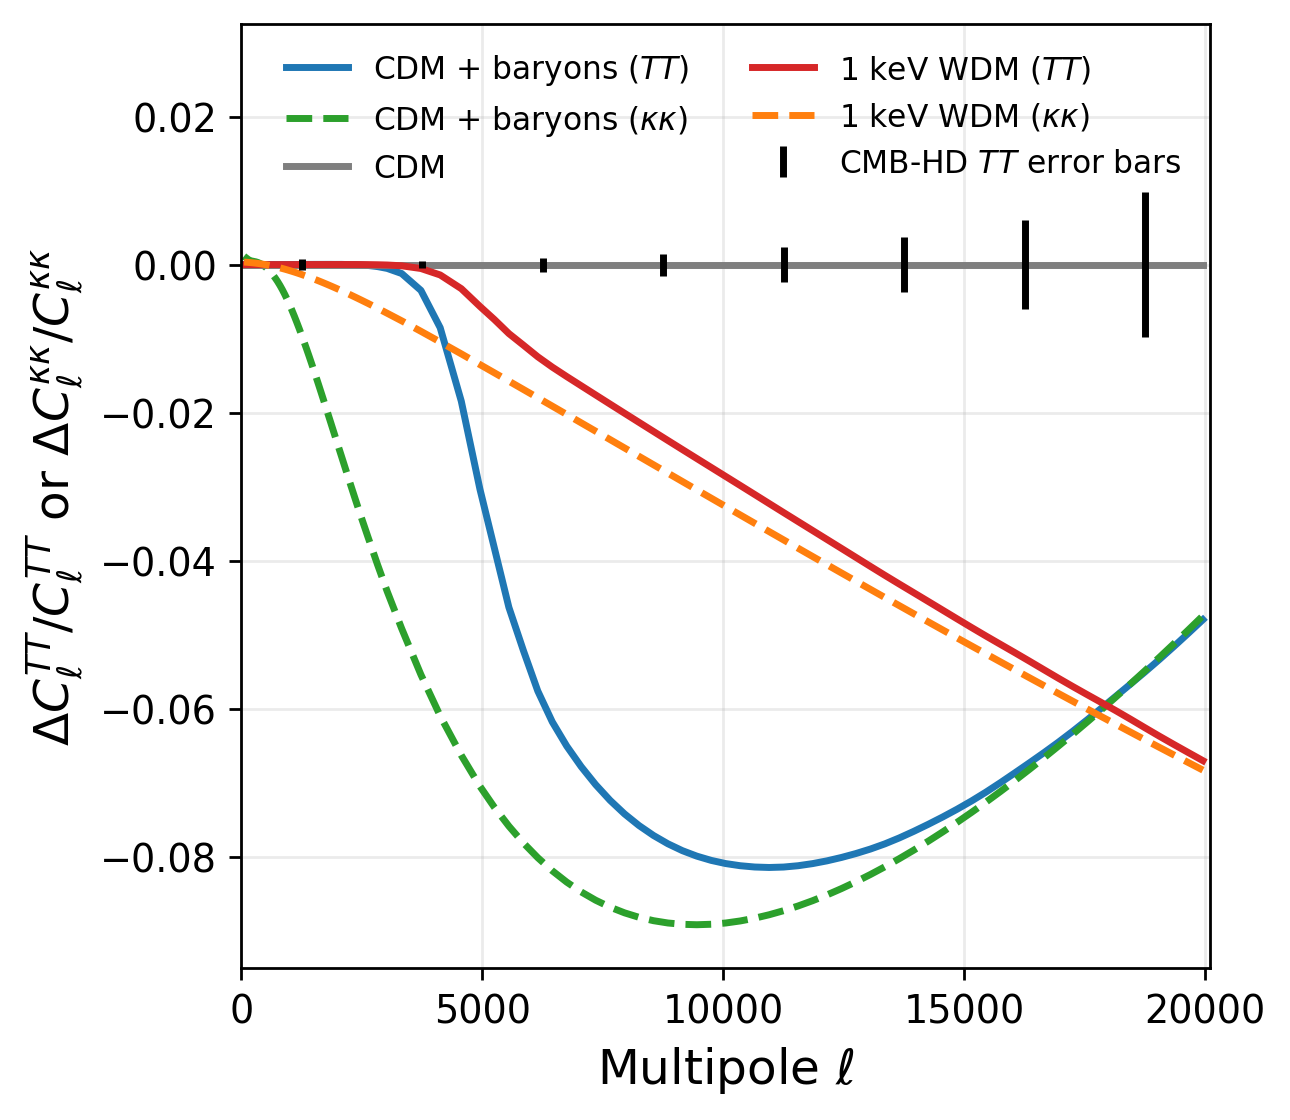

In [7]:
labelsize = 14
legendsize = 12
ticksize = 11
lw = 2

lbin20k = bmat20k @ ells[2:lmax+1]
cltt_cdm = bmat20k @ cdm_theo['tt'][2:lmax+1]
clkk_cdm = bmat20k @ cdm_theo['kk'][2:lmax+1]
cltt_cdm_baryons = bmat20k @ cdm_baryons_theo['tt'][2:lmax+1]
clkk_cdm_baryons = bmat20k @ cdm_baryons_theo['kk'][2:lmax+1]
cltt_wdm = bmat20k @ wdm_1keV_theo['tt'][2:lmax+1]
clkk_wdm = bmat20k @ wdm_1keV_theo['kk'][2:lmax+1]

plt.figure(figsize=(5,5))
plt.plot(lbin20k, ((cltt_cdm_baryons - cltt_cdm)/cltt_cdm), 
         '-', lw=lw, color='tab:blue', label=r'CDM + baryons ($TT$)')
plt.plot(lbin20k, ((clkk_cdm_baryons - clkk_cdm)/clkk_cdm), 
         '--', lw=lw, color='tab:green', label=r'CDM + baryons ($\kappa\kappa$)')
plt.plot(lbin20k, np.zeros(len(lbin20k)),ls='-', 
          lw=lw, color='tab:gray', label=r'CDM')
plt.plot(lbin20k,((cltt_wdm - cltt_cdm)/cltt_cdm), 
         '-', lw=lw, color='tab:red', label=r'1 keV WDM ($TT$)')
plt.plot(lbin20k,((clkk_wdm - clkk_cdm)/clkk_cdm), 
         '--', lw=lw, color='tab:orange', label=r'1 keV WDM ($\kappa\kappa$)') 
loc = np.where(plt_lbin <= lmax)
plt.errorbar(plt_lbin[loc], np.zeros(len(plt_lbin[loc])), 
             yerr=cltt_errors_knox[loc]/(plt_bmat @ cdm_theo['tt'][2:])[loc],
             ls='none', lw=lw, color='k', label=r'CMB-HD $TT$ error bars', zorder=5)
plt.grid(alpha=0.25)
plt.xlabel(r'Multipole $\ell$', fontsize=labelsize)
plt.ylabel(r'$\Delta C_\ell^{TT} / C_\ell^{TT}$ or $\Delta C_\ell^{\kappa\kappa} / C_\ell^{\kappa\kappa}$', fontsize=labelsize)
plt.legend(loc='upper right', fontsize=9, frameon=False, ncol=2, )
plt.xticks([0, 5000, 10000, 15000, 20000], fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlim([0,20100])
plt.ylim([-0.095, 0.0325])
if save:
    plt.savefig(os.path.join(output_dir, 'fig04.pdf'), dpi=250,  bbox_inches='tight')
plt.show()

## Compare the change in the high-$\ell$ $TT$+kSZ power due to 5 keV WDM vs. varying the slope of the kSZ power (Figure 5)

First we apply our WDM transfer function to the kSZ power spectrum, in order to approximate the suppression of the kSZ power due to WDM. (The suppression of $C_\ell^{TT}$ is already present in the pre-computed theory curve).

In [8]:
_, cl_ksz = datalib.cl_ksz()
z0 = 0.5 # evaluate transfer function at this redshift
# get the wavenumbers corresponding to our multipoles at this redshift:
camb_params_dict = cmb_from_pk.fid_params(only_camb=True) 
pars = camb.set_params(**camb_params_dict)
bg_results = camb.get_background(pars)
chi0 = bg_results.comoving_radial_distance(z0)
ks_xfer = (ells + 0.5) / chi0
# get the transfer function and apply it to the kSZ power spectrum:
h = 0.6736 # reduced hubble constant
Omega_dm = 0.12 / h**2 # dark matter density parameter
cl_ksz_wdm = cl_ksz * cmb_from_pk.wdm_transfer(ks_xfer, z0, 5, Omega_dm, h)
cl_ksz_wdm[:2] = 0

/home/amacinnis/anaconda3/envs/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in power
/home/amacinnis/anaconda3/envs/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


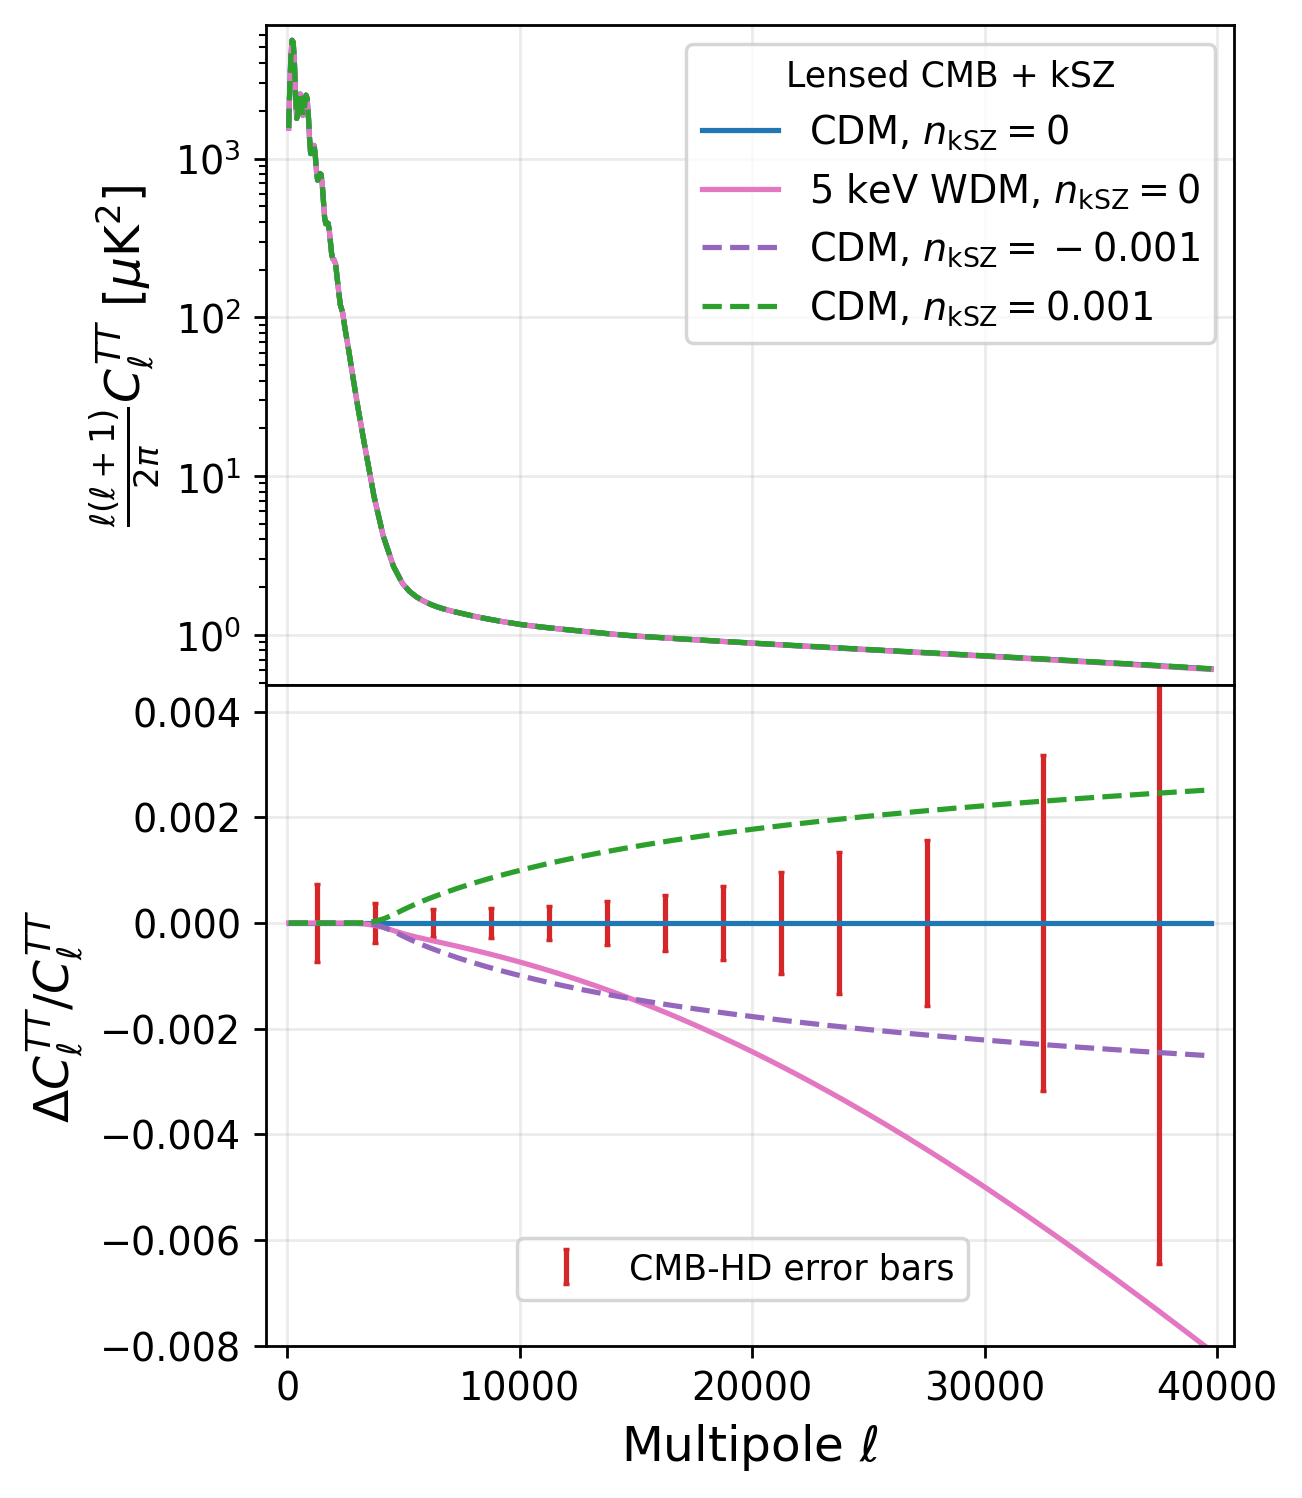

In [9]:
cltt = cmb_from_pk.load_precomputed_theory_spectra('lensed')['tt']
cl_fid = cltt + cl_ksz
cltt_wdm = cmb_from_pk.load_precomputed_theory_spectra('lensed', m_wdm=5)['tt']
cl_wdm = cltt_wdm + cl_ksz_wdm
lfact = ells * (ells + 1) / (2 * np.pi)
lbin = bmat40k @ ells[2:]

labelsize = 14
legendsize = 11
ticksize = 11

# make the figure and the subplots:
fig = plt.figure(figsize=(5,7), facecolor='w')
ax1 = fig.add_subplot(2, 1, 1)
ax1.margins(0.025)
ax2 = fig.add_subplot(2, 1, 2)
ax2.margins(0.025)

# n_ksz = 0, top panel:
ax1.plot(lbin, bmat40k @ (cl_fid[2:] * lfact[2:]), color='tab:blue', label=r'CDM, $n_\mathrm{kSZ} = 0$')
# bottom panel: plot error bars
ax2.plot(lbin, np.zeros(len(lbin)), color='tab:blue')
ax2.errorbar(plt_lbin, np.zeros(plt_lbin.shape), color='tab:red', ls='none', capsize=1, 
             yerr=cltt_errors_knox / (plt_bmat @ cl_fid[2:]), 
             label='CMB-HD error bars')

# WDM:
ax1.plot(lbin, bmat40k @ (cl_wdm[2:] * lfact[2:]), '-',
         color='tab:pink', label=r'5 keV WDM, $n_\mathrm{kSZ} = 0$')
cl_diff = cl_wdm - cl_fid
ax2.plot(lbin,  (bmat40k @ cl_diff[2:]) / (bmat40k @ cl_fid[2:]),  '-', color='tab:pink')

# vary the slope of the kSZ power spectrum for CDM:
for n, c in zip([-0.001,  0.001], ['tab:purple',  'tab:green']):
    label = r'CDM, $n_\mathrm{kSZ} = %.3f$' % n 
    cl = cltt + cl_ksz * (ells/3000)**n
    dl = bmat40k @ (cl[2:] * lfact[2:])
    ax1.plot(lbin, dl, color=c, label=label, ls='--')
    cl_diff = cl - cl_fid
    ax2.plot(lbin, (bmat40k @ cl_diff[2:]) / (bmat40k @ cl_fid[2:]), color=c, ls='--')
                     
for ax in [ax1, ax2]:
    ax.grid(alpha=0.25)
    ax.tick_params(labelsize=ticksize)
ax1.legend(fontsize=legendsize, ncol=1, title='Lensed CMB + kSZ')
ax2.legend(loc=(0.26,0.07))
ax2.set_xlabel(r'Multipole $\ell$', fontsize=labelsize)
ax2.set_ylabel(r'$\Delta C_\ell^{TT} / C_\ell^{TT}$', fontsize=labelsize)
ax1.set_ylabel(r'$\frac{\ell(\ell + 1)}{2\pi} C_\ell^{TT}~[\mu\mathrm{K}^2]$', fontsize=labelsize)
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax2.set_ylim([-0.008, 0.0045])
plt.subplots_adjust(hspace=0)
if save:
    plt.savefig(os.path.join(output_dir, 'fig05.pdf'), bbox_inches='tight', dpi=250)
plt.show()

---

# Parameter forecasts



Define some constants and functions to print or plot the results:

In [10]:
# list of varied parameters:
param_list = ['ombh2', 'omch2', 'theta', 'logA', 'ns', 'tau', 'nnu', 'mnu', 
              'A_ksz', 'n_ksz', 'HMCode_logT_AGN', 'm_wdm']

# fiducial parameter values:
params_dict = cmb_from_pk.fid_params(baryonic_feedback=True)
fid_params = {param: params_dict[param] for param in param_list}
# SZ prior:
baryonic_feedback_prior = {'HMCode_logT_AGN': 0.0006 * fid_params['HMCode_logT_AGN']}

# labels for triangle plots:
param_labels = {'logA': r'\ln \left(10^{10} A_\mathrm{s}\right)', 
                'ns': r'n_\mathrm{s}', 'tau': r'\tau', 
                'theta': r'100\theta_\mathrm{MC}',
                'ombh2': r'\Omega_\mathrm{b} h^2',
                'omch2': r'\Omega_\mathrm{d} h^2', 
                'nnu': r'N_\mathrm{eff}', 'mnu': r'\sum m_\nu',
                'HMCode_logT_AGN': r'\log T_\mathrm{AGN}', 
                'm_wdm': r'm_\mathrm{WDM}',
                'A_ksz': r'A_\mathrm{kSZ}', 'n_ksz': r'n_\mathrm{kSZ}'}

# number of digits to use when rounding the uncertainty of each parameter:
ndigits = {'ombh2': 6, 'omch2': 5, 'logA': 4, 'ns': 4, 'tau': 4, 'theta': 6,
           'theta': 6, 'nnu': 3, 'mnu': 3, 'HMCode_logT_AGN': 4, 'm_wdm': 3, 'A_ksz': 5,  'n_ksz': 5}
ndigits_ratio = {param: 2 for param in ndigits.keys()}


def getdist_samples(fisher_matrix, fisher_params, fid_params=fid_params):
    """Returns the `getdist.mcsamples.MCSamples` instance for the 
    `fisher_matrix` (two-dimensional array of float), with the order
    of the parameters in the rows/columns given by the list of 
    parameter names, `fisher_params`.
    """
    fids = [fid_params[p] for p in fisher_params] 
    labels = [param_labels[p] for p in fisher_params]
    samples = GaussianND(fids, fisher_matrix, is_inv_cov=True, names=fisher_params, labels=labels)
    return samples


# helpful functions to print out tables:

def round_dict(d, ndigits=ndigits):
    """Given a dictionary `d` with numerical values, round each value 
    to the number of digits for that key, given by the `ndigits` dict."""
    rounded = {}
    for key, val in d.items():
        rounded[key] = round(val, ndigits[key])
    return rounded

def ratio(dict1, dict2, fill_value=None):
    """Returns a dictionary with the ratio of the values in `dict1` to those 
    in `dict2` for each key they share in common. If the keys don't match, you
    can pass a `fill_value` as a placeholder for any keys not in both dictionaries;
    otherwise leave it as `None` to exclude those keys from the returned dictionary."""
    rdict = {}
    keys1 = list(dict1.keys())
    keys2 = list(dict2.keys())
    all_keys = list(set(keys1 + keys2))
    for key in all_keys:
        if (key in dict1) and (key in dict2):
            rdict[key] = dict1[key] / dict2[key]
        elif fill_value is not None:
            rdict[key] = fill_value
    return rdict

def print_table(list_of_dicts, list_of_labels, title=None, list_of_keys=None):
    """
    Display a table of keys and values held in each dictionary in the `list_of_dicts`.
    
    list_of_dicts : list of dictionaries.
    list_of_labels : list holding a label (str) for each dictionary in `list_of_dicts`, in the same order.
    title : a title that is printed out above the table.
    list_of_keys : list of dictionary keys to use as the rows of the table.
    """
    table = pd.DataFrame(list_of_dicts, index=list_of_labels, columns=list_of_keys)
    table = table.T
    title = ' ' if title is None else title
    table.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '26px')
    ]}])
    print('\n', title) 
    display(table)

Below we load the Fisher matrices. We include a prior on $\tau$ of $\sigma(\tau) = 0.007$ from _Planck_, and in cases where we include baryonic feedback, we forecast with and without a SZ prior on the baryonic feedback parameter $\log_{10}\left(T_\mathrm{AGN}/\mathrm{K}\right)$. We also include DESI BAO.

In [11]:
# store the fisher matrices and the order of the parameters in each:
fmats = {}
fisher_params = {}
fmats_no_ksz = {}
fisher_params_no_ksz = {}

for m_wdm in [None] + masses:
    if m_wdm is None:
        model = 'cdm'
        model_info = 'CDM'
    else:
        model = f'wdm_mass{m_wdm}'
        model_info = f'{m_wdm} keV WDM'
    for baryonic_feedback in [False, True]:
        if baryonic_feedback:
            key = f'{model}_baryons'
            model_info = f'{model_info} + baryons'
        else:
            key = model

        print(f'loading fisher matrix for {model_info}')
        # CMB-only, with kSZ
        fmats[key], fisher_params[key] = cmb_from_pk.load_precomputed_fisher_matrix(cmb_type, m_wdm=m_wdm, 
                                                                                    baryonic_feedback=baryonic_feedback, 
                                                                                    with_ksz=True, with_desi=False)
        # CMB + DESI BAO, with kSZ
        fmats[f'{key}_bao'], fisher_params[f'{key}_bao'] = cmb_from_pk.load_precomputed_fisher_matrix(cmb_type, m_wdm=m_wdm, 
                                                                                                      baryonic_feedback=baryonic_feedback,  
                                                                                                      with_ksz=True, with_desi=True)
        
        # CMB-only, without kSZ
        fmats_no_ksz[key], fisher_params_no_ksz[key] = cmb_from_pk.load_precomputed_fisher_matrix(cmb_type, m_wdm=m_wdm, 
                                                                                     baryonic_feedback=baryonic_feedback, 
                                                                                     with_ksz=False, with_desi=False)
        # CMB + DESI BAO, without kSZ
        fmats_no_ksz[f'{key}_bao'], fisher_params_no_ksz[f'{key}_bao'] = cmb_from_pk.load_precomputed_fisher_matrix(cmb_type, m_wdm=m_wdm, 
                                                                                                       baryonic_feedback=baryonic_feedback,  
                                                                                                       with_ksz=False, with_desi=True)
         # if we're varying the baryonic feedback parameter, add a prior on it:
        if baryonic_feedback:
            fisher_params[f'{key}_szprior'] = fisher_params[key].copy()
            fmats[f'{key}_szprior'] = fisher.add_priors(fmats[key].copy(), fisher_params[key], baryonic_feedback_prior)
            fisher_params[f'{key}_bao_szprior'] = fisher_params[f'{key}_bao'].copy()
            fmats[f'{key}_bao_szprior'] = fisher.add_priors(fmats[f'{key}_bao'].copy(), fisher_params[f'{key}_bao'], baryonic_feedback_prior)
            
            fisher_params_no_ksz[f'{key}_szprior'] = fisher_params_no_ksz[key].copy()
            fmats_no_ksz[f'{key}_szprior'] = fisher.add_priors(fmats_no_ksz[key].copy(), fisher_params_no_ksz[key], baryonic_feedback_prior)
            fisher_params_no_ksz[f'{key}_bao_szprior'] = fisher_params_no_ksz[f'{key}_bao'].copy()
            fmats_no_ksz[f'{key}_bao_szprior'] = fisher.add_priors(fmats_no_ksz[f'{key}_bao'].copy(), fisher_params_no_ksz[f'{key}_bao'], baryonic_feedback_prior)

loading fisher matrix for CDM
loading fisher matrix for CDM + baryons
loading fisher matrix for 1 keV WDM
loading fisher matrix for 1 keV WDM + baryons
loading fisher matrix for 2 keV WDM
loading fisher matrix for 2 keV WDM + baryons
loading fisher matrix for 3 keV WDM
loading fisher matrix for 3 keV WDM + baryons
loading fisher matrix for 4 keV WDM
loading fisher matrix for 4 keV WDM + baryons
loading fisher matrix for 5 keV WDM
loading fisher matrix for 5 keV WDM + baryons
loading fisher matrix for 6 keV WDM
loading fisher matrix for 6 keV WDM + baryons
loading fisher matrix for 7 keV WDM
loading fisher matrix for 7 keV WDM + baryons
loading fisher matrix for 8 keV WDM
loading fisher matrix for 8 keV WDM + baryons
loading fisher matrix for 9 keV WDM
loading fisher matrix for 9 keV WDM + baryons
loading fisher matrix for 10 keV WDM
loading fisher matrix for 10 keV WDM + baryons
loading fisher matrix for 11 keV WDM
loading fisher matrix for 11 keV WDM + baryons
loading fisher matrix fo

Get the $1\sigma$ uncertainty on each parameter from each Fisher matrix, and get the `getdist` samples for each Fisher matrix (used to make the triangle plots):

In [12]:
# get the parameter uncertainty from the Fisher matrix, and the `getdist` samples for plotting:
errors = {}
samples = {}
for key in fmats.keys():
    errors[key] = fisher.get_fisher_errors(fmats[key], fisher_params[key])
    fids = fid_params.copy() # fiducial parameter values
    if 'wdm' in key: 
        m = float(key.split('_')[1][4:])
        fids['m_wdm'] = m
    samples[key] = getdist_samples(fmats[key], fisher_params[key], fid_params=fids)

errors_no_ksz = {}
samples_no_ksz = {}
for key in fmats.keys():
    errors_no_ksz[key] = fisher.get_fisher_errors(fmats_no_ksz[key], fisher_params_no_ksz[key])
    fids = fid_params.copy() # fiducial parameter values
    if 'wdm' in key: 
        m = float(key.split('_')[1][4:])
        fids['m_wdm'] = m
    samples_no_ksz[key] = getdist_samples(fmats_no_ksz[key], fisher_params_no_ksz[key], fid_params=fids)

## Parameter forecasts for CDM-only, CDM + baryons, and 1 keV WDM + baryons (Table 4)

Below we print out a table of parameter uncertainties for models listed above, using a combination of CMB-HD and DESI BAO.

Note: you will see some `NaN`'s in the table below, which you should read as "N/A". These are just due to missing entries in the dictionary of parameter errors for a given model. For example, we don't vary the WDM mass in the CDM-only model, so there is no key for `m_wdm` in the dictionary for the CDM-only forecasts. The table handles this by printing a `NaN` instead.

In [13]:
table_keys = ['cdm_bao', 'cdm_baryons_bao_szprior', 'wdm_mass1_baryons_bao_szprior']
table_list = [round_dict(errors[key]) for key in table_keys]
table_labels = ['CDM', 'CDM + baryons + SZ prior', '1 keV WDM + baryons + SZ prior']
print_table(table_list, table_labels, list_of_keys=param_list, title='CMB-HD delensed TT, TE, EE, BB, kk + DESI BAO:\n')


 CMB-HD delensed TT, TE, EE, BB, kk + DESI BAO:



,CDM,CDM + baryons + SZ prior,1 keV WDM + baryons + SZ prior
ombh2,0.000025,0.000025,0.000025
omch2,0.000410,0.000410,0.000410
theta,0.000060,0.000060,0.000060
logA,0.010400,0.010900,0.011000
ns,0.001600,0.001600,0.001700
tau,0.005500,0.005800,0.005800
nnu,0.015000,0.016000,0.016000
mnu,0.026000,0.028000,0.028000
A_ksz,0.000760,0.000750,0.001210
n_ksz,0.000490,0.000490,0.001330


## Forecasts for the SNR for the WDM mass (Table 5 and Figure 1)


Below, we calculate the error bar on the WDM mass for masses between 1 and 12 keV, in the following cases:
1. When only $m_\mathrm{WDM}$ is free, and all other parameters are fixed to their fiducial values
2. When $m_\mathrm{WDM}$ and the kSZ parameters $A_\mathrm{kSZ}$, $n_\mathrm{kSZ}$ are free
3. When $m_\mathrm{WDM}$, $A_\mathrm{kSZ}$, $n_\mathrm{kSZ}$ and the six $\Lambda$WDM parameters are free
4. When $m_\mathrm{WDM}$, $A_\mathrm{kSZ}$, $n_\mathrm{kSZ}$ the six $\Lambda$WDM parameters, $N_\mathrm{eff}$, and $\sum m_\nu$ are free
5. When $m_\mathrm{WDM}$, $A_\mathrm{kSZ}$, $n_\mathrm{kSZ}$ the six $\Lambda$WDM parameters, $N_\mathrm{eff}$, $\sum m_\nu$, and the baryonic feedback parameter $\log_{10}(T_\mathrm{AGN}/\mathrm{K})$ are free, with a prior applied on the baryonic feedback parameter

In [14]:
# error bar on WDM mass when all other parameters are free, including baryonic feedback, with an SZ prior:
wdm_errors_baryons = {f'{m} keV': errors[f'wdm_mass{m}_baryons_bao_szprior']['m_wdm'] for m in masses}
# error bar on WDM mass, assuming no baryonic feedback:
wdm_errors_nobaryons = {f'{m} keV': errors[f'wdm_mass{m}_bao']['m_wdm'] for m in masses}
# error bar on WDM mass when only LCDM params are free, and when only the WDM mass itself is free:
wdm_errors_lwdm_ksz = {}
wdm_errors_ksz = {}
wdm_errors = {}
for m in masses:
    key = f'wdm_mass{m}_bao'
    # remove N_eff and m_nu:
    tmp_fmat, tmp_params = fisher.remove_params(fmats[key].copy(), fisher_params[key].copy(), ['nnu', 'mnu'])
    wdm_errors_lwdm_ksz[f'{m} keV'] = fisher.get_fisher_errors(tmp_fmat, tmp_params)['m_wdm']
    # remove the LWDM parameters:
    tmp_fmat, tmp_params = fisher.remove_params(tmp_fmat, tmp_params, ['logA', 'ns', 'ombh2', 'omch2', 'tau', 'theta'])
    wdm_errors_ksz[f'{m} keV'] = fisher.get_fisher_errors(tmp_fmat, tmp_params)['m_wdm']
    # remove the kSZ parameters:
    tmp_fmat, tmp_params = fisher.remove_params(tmp_fmat, tmp_params, ['A_ksz', 'n_ksz'])
    wdm_errors[f'{m} keV'] = fisher.get_fisher_errors(tmp_fmat, tmp_params)['m_wdm']

For each mass, we print two values in each column of the table: the error bar $\sigma(m_\mathrm{WDM})$ (in units of keV), and the SNR defined as $m_\mathrm{WDM}/\sigma(m_\mathrm{WDM})$

In [15]:
# get dicts of rounded error bars on WDM mass (easier to read)
def round_wdm_errors(wdm_error_dict, wdm_masses=masses):
    rounded = {}
    for m in wdm_masses:
        m_err = wdm_error_dict[f'{m} keV']
        if (m_err > 0.001) and (m_err <= 0.01):
            rounded[f'{m} keV'] = round(m_err, 4)
        elif (m_err > 0.01) and (m_err <= 0.1):
            rounded[f'{m} keV'] = round(m_err, 3)
        elif (m_err > 0.1) and (m_err <= 1):
            rounded[f'{m} keV'] = round(m_err, 2)
        elif (m_err > 1) and (m_err <= 10):
            rounded[f'{m} keV'] = round(m_err, 1)
        else:
            rounded[f'{m} keV'] = round(m_err, 0)
    return rounded

rounded_wdm_errors = round_wdm_errors(wdm_errors)
rounded_wdm_errors_ksz = round_wdm_errors(wdm_errors_ksz)
rounded_wdm_errors_lwdm_ksz = round_wdm_errors(wdm_errors_lwdm_ksz)
rounded_wdm_errors_nobaryons = round_wdm_errors(wdm_errors_nobaryons)
rounded_wdm_errors_baryons = round_wdm_errors(wdm_errors_baryons)

# format the columns in the table:
table_list = [{f'{m} keV': f"{rounded_wdm_errors[f'{m} keV']} ({round(m / rounded_wdm_errors[f'{m} keV'], 1)}"+r"$\sigma$)" for m in masses},
             {f'{m} keV': f"{rounded_wdm_errors_ksz[f'{m} keV']} ({round(m / rounded_wdm_errors_ksz[f'{m} keV'], 1)}"+r"$\sigma$)"  for m in masses},
             {f'{m} keV': f"{rounded_wdm_errors_lwdm_ksz[f'{m} keV']} ({round(m / rounded_wdm_errors_lwdm_ksz[f'{m} keV'], 1)}"+r"$\sigma$)"  for m in masses},
             {f'{m} keV': f"{rounded_wdm_errors_nobaryons[f'{m} keV']} ({round(m / rounded_wdm_errors_nobaryons[f'{m} keV'], 1)}"+r"$\sigma$)"  for m in masses},
             {f'{m} keV': f"{rounded_wdm_errors_baryons[f'{m} keV']} ({round(m / rounded_wdm_errors_baryons[f'{m} keV'], 1)}"+r"$\sigma$)"  for m in masses}]
print_table(table_list,
            [r'$m_\mathrm{WDM}$ only free', 
             r'$m_\mathrm{WDM}$ + kSZ', 
             r'$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$', 
             r'$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$ + $N_\mathrm{eff}$ + $\sum m_\nu$', 
             r'$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$ + $N_\mathrm{eff}$ + $\sum m_\nu$ + baryons + SZ prior'],
            list_of_keys=[f'{m} keV' for m in masses[:-2]])

,$m_\mathrm{WDM}$ only free,$m_\mathrm{WDM}$ + kSZ,$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$,$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$ + $N_\mathrm{eff}$ + $\sum m_\nu$,$m_\mathrm{WDM}$ + kSZ + $\Lambda\mathrm{WDM}$ + $N_\mathrm{eff}$ + $\sum m_\nu$ + baryons + SZ prior
1 keV,0.0023 (434.8$\sigma$),0.026 (38.5$\sigma$),0.032 (31.2$\sigma$),0.034 (29.4$\sigma$),0.034 (29.4$\sigma$)
2 keV,0.013 (153.8$\sigma$),0.2 (10.0$\sigma$),0.22 (9.1$\sigma$),0.22 (9.1$\sigma$),0.22 (9.1$\sigma$)
3 keV,0.044 (68.2$\sigma$),0.3 (10.0$\sigma$),0.31 (9.7$\sigma$),0.31 (9.7$\sigma$),0.31 (9.7$\sigma$)
4 keV,0.11 (36.4$\sigma$),0.56 (7.1$\sigma$),0.57 (7.0$\sigma$),0.58 (6.9$\sigma$),0.57 (7.0$\sigma$)
5 keV,0.24 (20.8$\sigma$),1.1 (4.5$\sigma$),1.1 (4.5$\sigma$),1.1 (4.5$\sigma$),1.1 (4.5$\sigma$)
6 keV,0.45 (13.3$\sigma$),1.9 (3.2$\sigma$),1.9 (3.2$\sigma$),1.9 (3.2$\sigma$),1.9 (3.2$\sigma$)
7 keV,0.73 (9.6$\sigma$),3.2 (2.2$\sigma$),3.2 (2.2$\sigma$),3.3 (2.1$\sigma$),3.2 (2.2$\sigma$)
8 keV,1.2 (6.7$\sigma$),4.8 (1.7$\sigma$),4.9 (1.6$\sigma$),5.0 (1.6$\sigma$),4.9 (1.6$\sigma$)
9 keV,1.8 (5.0$\sigma$),7.3 (1.2$\sigma$),7.5 (1.2$\sigma$),7.5 (1.2$\sigma$),7.5 (1.2$\sigma$)
10 keV,2.3 (4.3$\sigma$),11.0 (0.9$\sigma$),11.0 (0.9$\sigma$),11.0 (0.9$\sigma$),11.0 (0.9$\sigma$)


Compare the SNRs for the WDM mass in the last column above to the SNRs from lensing alone:

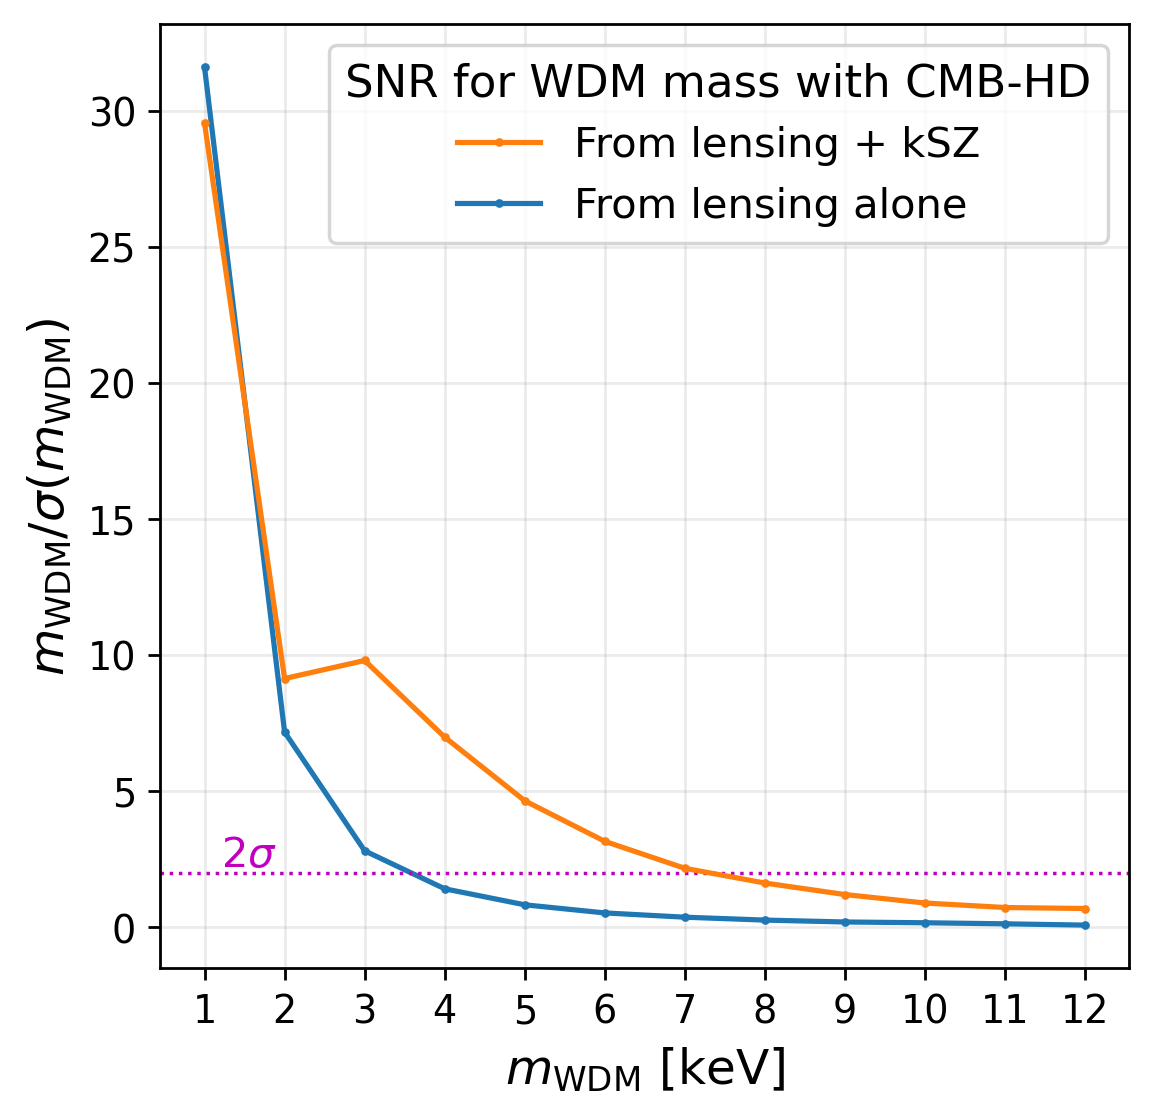

In [16]:
wdm_errors_baryons_no_ksz = {f'{m} keV': errors_no_ksz[f'wdm_mass{m}_baryons_bao_szprior']['m_wdm'] for m in masses}

labelsize = 14
legendsize = 12
ticksize = 11
plt.rcParams['legend.title_fontsize'] = 13

plt.figure(figsize=(5,5))
plt.plot(masses, [m / wdm_errors_baryons[f'{m} keV'] for m in masses], '.-', markersize=3, label='From lensing + kSZ', color='tab:orange', zorder=3)
plt.plot(masses, [m / wdm_errors_baryons_no_ksz[f'{m} keV'] for m in masses], '.-', markersize=3, label='From lensing alone', color='tab:blue')
plt.axhline(y=2, color='m', ls=':', lw=1)
plt.text(1.2, 2.25, r'$2\sigma$', fontsize=12, color='m')
plt.xlabel(r'$m_\mathrm{WDM}$ [keV]', fontsize=labelsize)
plt.ylabel(r'$m_\mathrm{WDM} / \sigma(m_\mathrm{WDM})$', fontsize=labelsize)
plt.xticks(np.arange(1, 13), fontsize=ticksize)
plt.legend(title='SNR for WDM mass with CMB-HD', fontsize=legendsize, loc='upper right')
plt.grid(alpha=0.25)
plt.tick_params(labelsize=ticksize)
if save:
    plt.savefig(os.path.join(output_dir, 'fig01.pdf'), bbox_inches='tight', dpi=250)
plt.show()

plt.rcParams['legend.title_fontsize'] = None

## Triangle plots 

__Note__: the last plot may take a long time to finish (likely at least 20 minutes).

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


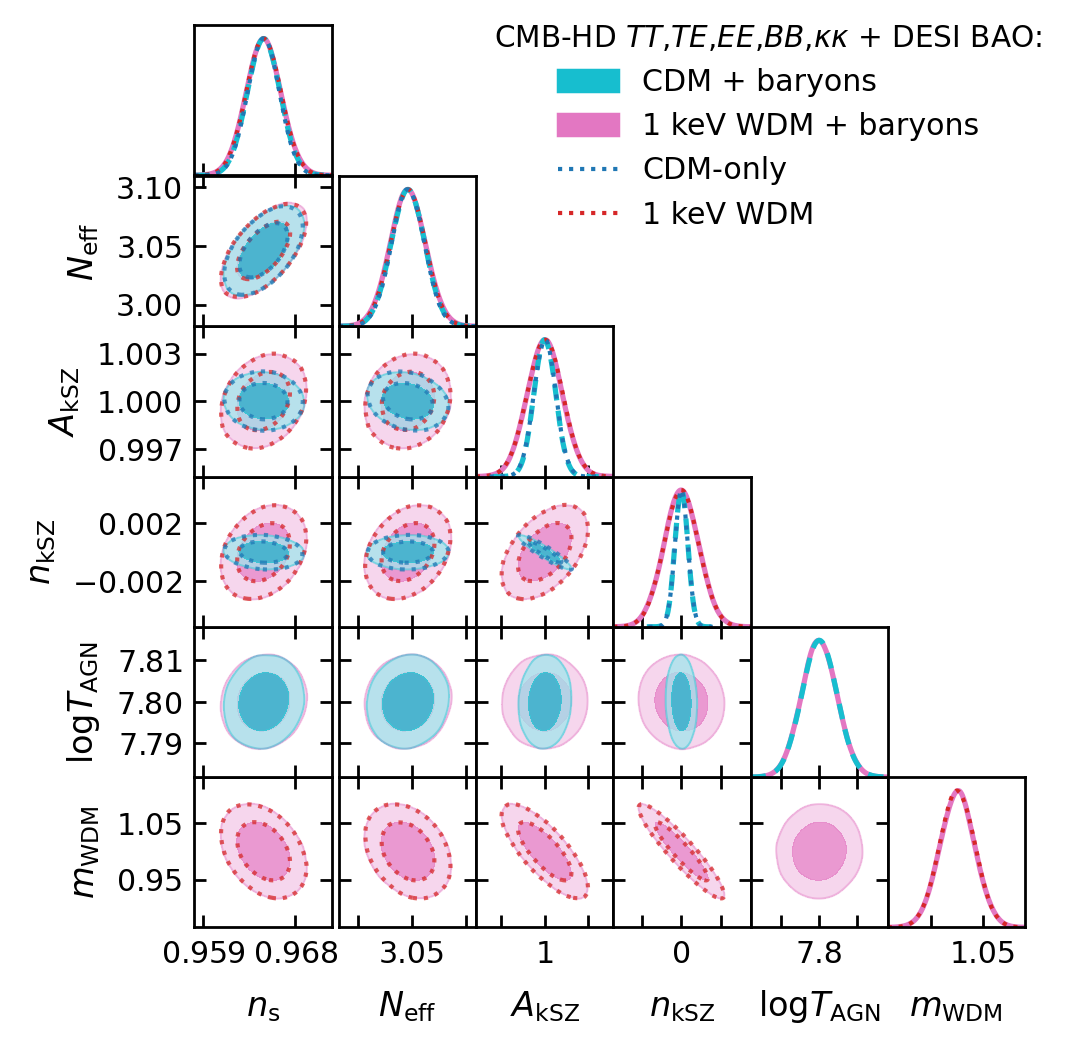

In [17]:
plt_params = ['ns', 'nnu', 'A_ksz', 'n_ksz', 'HMCode_logT_AGN', 'm_wdm',]
plt_keys = ['wdm_mass1_baryons_bao_szprior', 'cdm_baryons_bao_szprior',  'wdm_mass1_bao',  'cdm_bao']
legend_labels = ['1 keV WDM + baryons', 
                 'CDM + baryons',
                 '1 keV WDM',
                 'CDM-only']
colors = ['tab:pink', 'tab:cyan', 'tab:red', 'tab:blue']
filled = [True, True, False, False]
ls = ['-', '--', ':', ':']
lw = [1.5, 1.5, 1.2, 1.2]
plt.rcParams['legend.title_fontsize'] = 8.5
n = 100000
plt_samples = [samples[key].MCSamples(n) for key in plt_keys]

g = ps.get_subplot_plotter(width_inch=4)
g.settings.scaling_factor = 1
g.settings.legend_fontsize = 11.5
g.settings.axes_fontsize = 11.5
g.settings.axes_labelsize = 12.5
g.settings.constrained_layout = True
g.settings.figure_legend_frame = False
g.triangle_plot(plt_samples,
                params=plt_params,
                filled=filled, 
                diag1d_kwargs={'lws': lw, 'ls': ls},
                contour_colors=colors, 
                contour_args={'alpha': 0.75},
                ls=ls, lws=lw,
                label_order=[1, 0, 3, 2],
                legend_loc=(0.45, 0.77),
                legend_labels=legend_labels)
g.legend.set_title(r'CMB-HD $TT$,$TE$,$EE$,$BB$,$\kappa\kappa$ + DESI BAO:')

# manually adjust the axis ticks:
# ns:
g.subplots[5,0].set_xticks([0.959, 0.968])
# N_eff:
g.subplots[1,0].set_yticks([3, 3.05, 3.1])
g.subplots[5,1].set_xticks([3, 3.05, 3.1])
g.subplots[5,1].set_xticklabels(['', '3.05', ''])
# A_ksz:
g.subplots[5,2].set_xticks([0.997, 1, 1.003])
g.subplots[5,2].set_xticklabels(['', '1', ''])
# n_ksz:
g.subplots[5,3].set_xticks([-0.003, 0, 0.003])
g.subplots[5,3].set_xticklabels(['', '0', ''])
# log(T_AGN):
g.subplots[4,0].set_yticks([7.79, 7.8, 7.81])
g.subplots[5,4].set_xticks([7.79, 7.8, 7.81])
g.subplots[5,4].set_xticklabels(['', '7.8', ''])
# m_wdm:
g.subplots[5,0].set_yticks([0.95, 1.05])
g.subplots[5,5].set_xticks([0.95, 1.05])
g.subplots[5,5].set_xticklabels(['', '1.05'])

if save:
    plt.savefig(os.path.join(output_dir, 'fig07.pdf'), bbox_inches='tight', dpi=250)
plt.show()

plt.rcParams['legend.title_fontsize'] = None

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


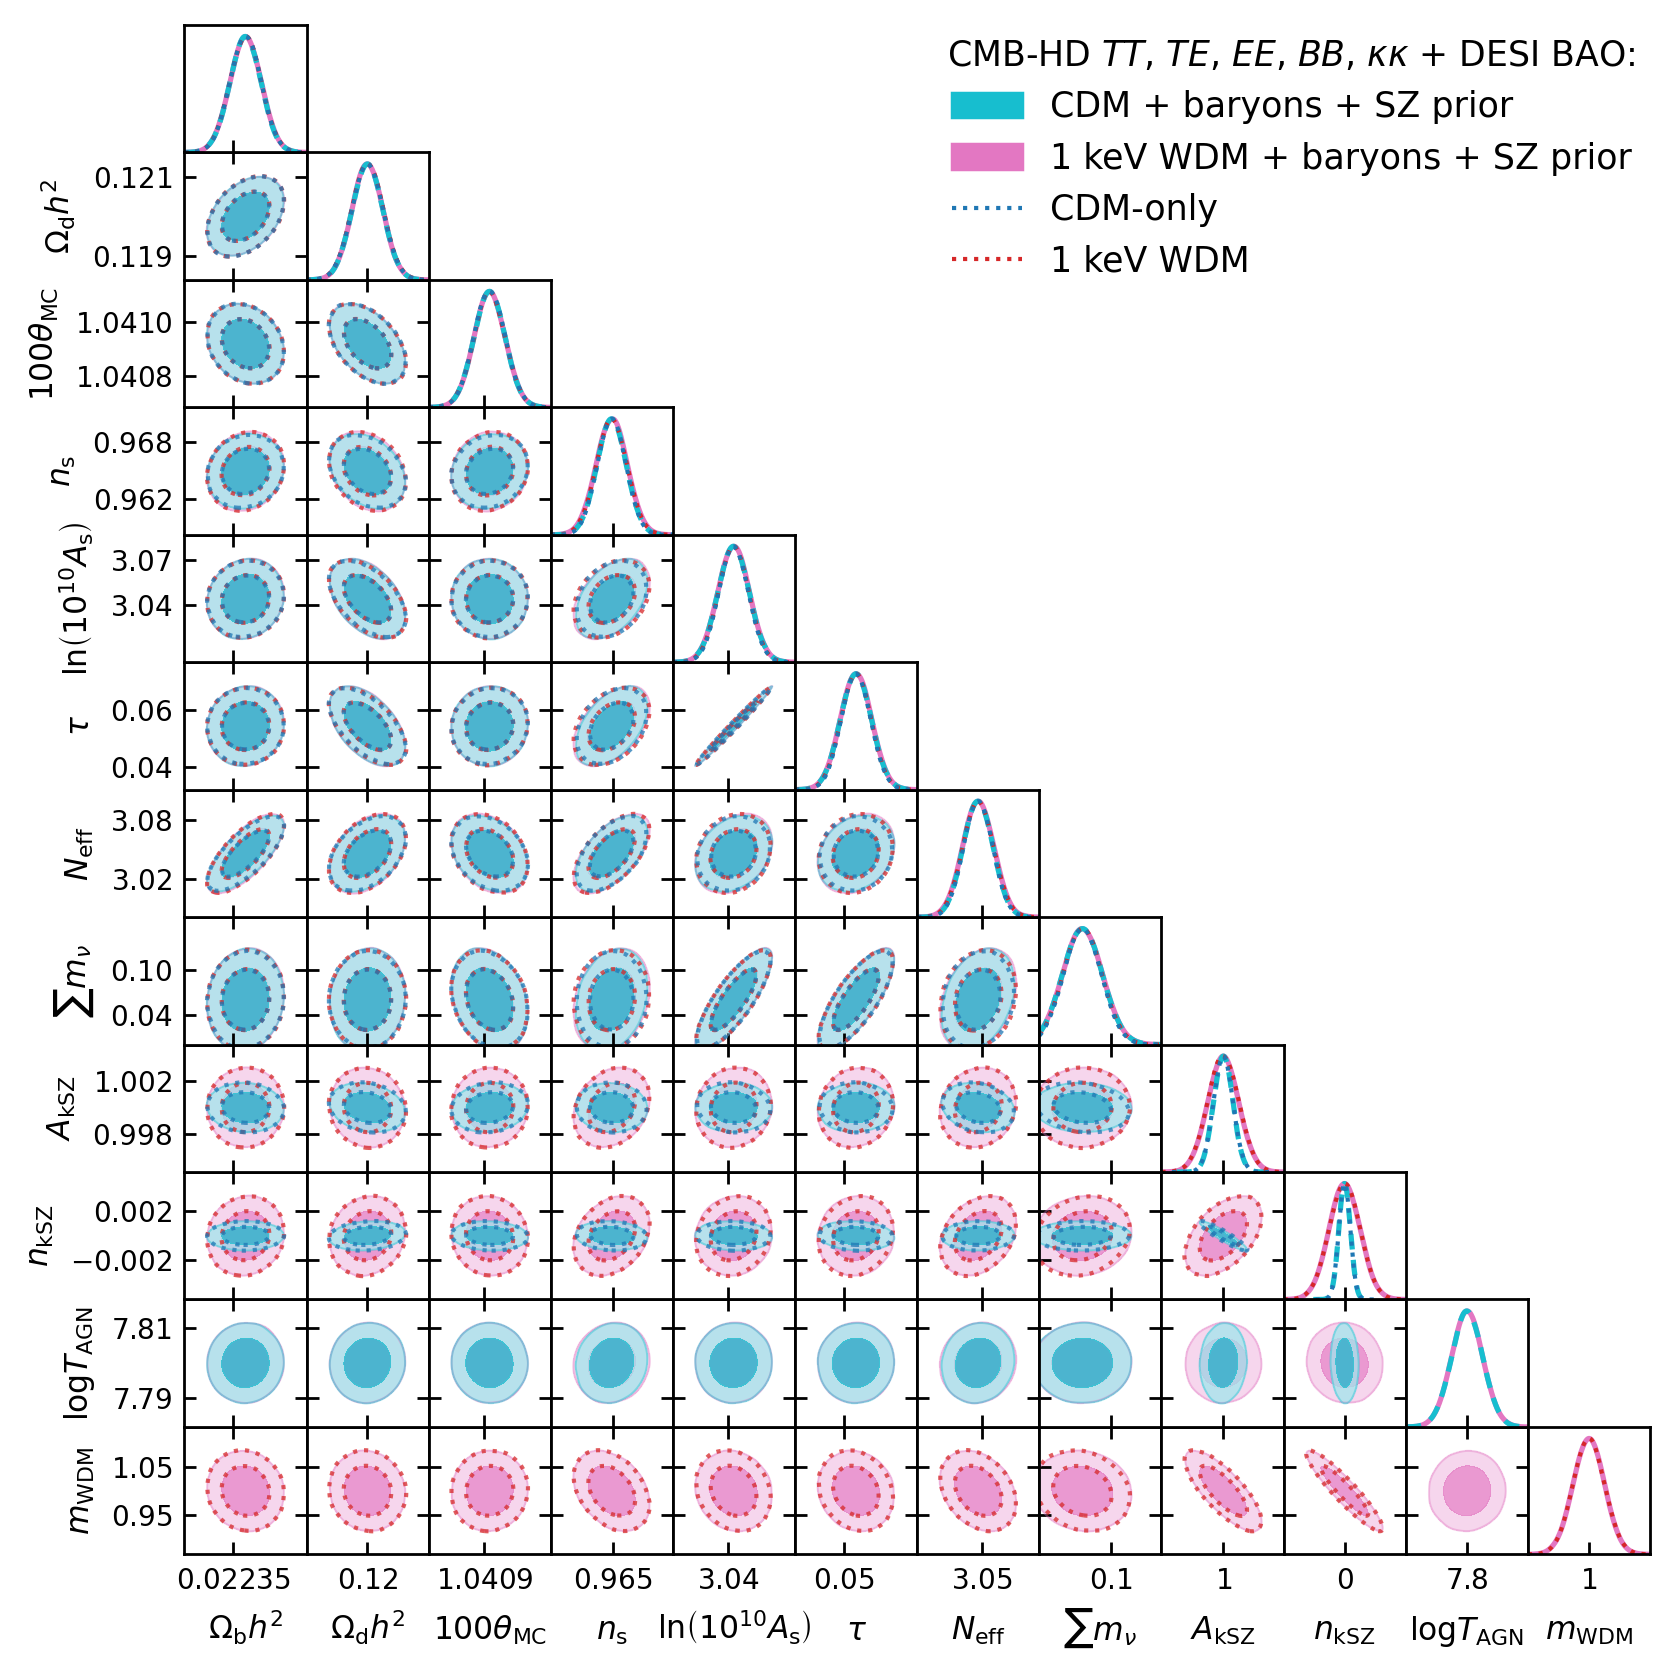

In [18]:
plt_params = ['ombh2',
             'omch2',
             'theta',
             'ns',
             'logA',
             'tau',
             'nnu',
             'mnu',
             'A_ksz',
             'n_ksz',
             'HMCode_logT_AGN',
             'm_wdm']
plt_keys = ['wdm_mass1_baryons_bao_szprior', 'cdm_baryons_bao_szprior',  'wdm_mass1_bao',  'cdm_bao']
legend_labels = ['1 keV WDM + baryons + SZ prior', 
                 'CDM + baryons + SZ prior',
                 '1 keV WDM',
                 'CDM-only']
colors = ['tab:pink', 'tab:cyan', 'tab:red', 'tab:blue']
filled = [True, True, False, False]
ls = ['-', '--', ':', ':']
lw = [1.5, 1.5, 1.2, 1.2]
plt.rcParams['legend.title_fontsize'] = 10
n = 100000
plt_samples = [samples[key].MCSamples(n) for key in plt_keys]

g = ps.get_subplot_plotter(width_inch=6.5)
g.settings.scaling_factor = 1
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 11
g.settings.axes_labelsize = 12#.5
g.settings.constrained_layout = True
g.settings.figure_legend_frame = False
g.triangle_plot(plt_samples,
                params=plt_params,
                filled=filled, param_limits={'mnu': [0, None]},
                diag1d_kwargs={'lws': lw, 'ls': ls},
                contour_colors=colors, 
                contour_args={'alpha': 0.75},
                ls=ls, lws=lw,
                label_order=[1, 0, 3, 2],
                legend_loc='upper right',
                legend_labels=legend_labels)
g.legend.set_title(r'CMB-HD $TT$, $TE$, $EE$, $BB$, $\kappa\kappa$ + DESI BAO:')
# manually adjust a few of the axis ticks:
g.subplots[-1,0].set_xticks([0.02235])
g.subplots[-1,3].set_xticks([0.965])
g.subplots[-1,6].set_xticks([3.05])

if save:
    plt.savefig(os.path.join(output_dir, 'fig08.pdf'), bbox_inches='tight', dpi=250)
plt.show()

plt.rcParams['legend.title_fontsize'] = None